In [8]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
from torch.optim import lr_scheduler
from time import time
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm

In [9]:
train_data = pd.read_csv("train.csv",
                         dtype={"ID_code": np.str, "target": np.bool})

test_data = pd.read_csv("test.csv",
                         dtype={"ID_code": np.str, "target": np.bool})

test_data = test_data.drop(['ID_code'], axis = 1)
test_data = ((test_data-test_data.min())/(test_data.max()-test_data.min()))
#############TRAIN ON PART (SANITY TEST)
#train_data = train_data.head(2000)

train_y = train_data.target
train_x = train_data.drop(['target', 'ID_code'], axis=1)
train_x = ((train_x-train_x.min())/(train_x.max()-train_x.min()))

In [10]:
 X_train, X_test, y_train, y_test = train_test_split(
     train_x, train_y, test_size=0.25, random_state=333)

In [11]:
train_x.shape

(200000, 200)

In [12]:
batch_size = 256
hidden_size = 512

tensor_x = torch.tensor(X_train.values).float()
tensor_y = torch.tensor(y_train.values.astype(np.int32)).float().view(-1,1)
tensor_test_x = torch.tensor(X_test.values).float()
tensor_test_y = torch.tensor(y_test.values.astype(np.int32)).float().view(-1,1)

train_dataset = TensorDataset(tensor_x, tensor_y)
dataloader = DataLoader(train_dataset, batch_size = batch_size,
                                         num_workers = 6, shuffle = True)

test_dataset = TensorDataset(tensor_test_x, tensor_test_y)
dataloader_test = DataLoader(test_dataset, batch_size = batch_size,
                                         num_workers = 6, shuffle = False)
#print(next(iter(dataloader))[0][0])
#print(next(iter(dataloader))[1][0])

In [13]:
class Net(nn.Module):

    def __init__(self, input_size, hidden_dim, batch_size, output_dim=1):
        super(Net, self).__init__()
        self.input_size = input_size
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        
        self.lin1 = nn.Linear(input_size, hidden_dim)
        self.lin2 = nn.Linear(hidden_dim, hidden_dim)
        self.lin3 = nn.Linear(hidden_dim, output_dim)
        #self.selu = nn.functional.selu()
        self.sigmoid = nn.Sigmoid()
        #Alpha Dropout is a Dropout that keeps mean and variance of inputs to their original values,
        #in order to ensure the self-normalizing property even after this dropout.
        self.dropout = nn.AlphaDropout(p=0.5)
        self.batchnorm = nn.BatchNorm1d(hidden_dim).cuda()
        
        
    def forward(self, input):
        # Forward pass through FFN
        layer1 = self.lin1(input)
        #layer1 = self.batchnorm(layer1)
        layer1 = self.dropout(layer1)
        ##########Scaled Exponential Linear Unit - https://towardsdatascience.com/selu-make-fnns-great-again-snn-8d61526802a9
        layer1 = nn.functional.selu(layer1)
        layer2 = self.lin2(layer1)
        #layer2 = self.batchnorm(layer2)
        layer2 = self.dropout(layer2)
        layer2 = nn.functional.selu(layer2)
        layer3 = self.lin2(layer2)
        #layer3 = self.batchnorm(layer3)
        layer3 = self.dropout(layer3)
        layer3 = nn.functional.selu(layer3)
        layer4 = self.lin3(layer3)
        y_pred = self.sigmoid(layer4)
        return y_pred

model = Net(input_size=200, hidden_dim=hidden_size, batch_size=batch_size).cuda()
print(model)

Net(
  (lin1): Linear(in_features=200, out_features=512, bias=True)
  (lin2): Linear(in_features=512, out_features=512, bias=True)
  (lin3): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
  (dropout): AlphaDropout(p=0.5)
  (batchnorm): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [14]:
loss_fn = torch.nn.BCELoss()
learning_rate = 1e-6
optimiser = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum = 0.9)
#After 100 epochs LR will be on ~ 13% of the initial value
lr_sched = lr_scheduler.ExponentialLR(optimiser, gamma=98e-2, last_epoch=-1)

#####################
# Train model
#####################
num_epochs = 100
hist = np.zeros((2, num_epochs))


predictions = []

for i in range(4):
    predictions.append(np.array([]))

roc_score = 0.0

model.train()
for t in tqdm(range(num_epochs)):
    lr_sched.step()
    for step, batch in enumerate(dataloader):
        # Zero out gradient, else they will accumulate between epochs
        optimiser.zero_grad()

        x = batch[0].cuda()
        y = batch[1].cuda()
            
        # Forward pass
        y_pred = model(x)

        loss = loss_fn(y_pred, y)
        

        predictions[0] = np.append(predictions[0], y.cpu().numpy().reshape(-1), axis = 0)
        predictions[1] = np.append(predictions[1], y_pred.detach().cpu().numpy().reshape(-1), axis = 0)    
            
        hist[0][t] = loss.item()

         # Backward pass
        loss.backward()
        
         # Update parameters
        optimiser.step()
        
    for test_batch in dataloader_test:
        x_test = test_batch[0].cuda()
        y_test = test_batch[1].cuda()
        test_pred = model(x_test)
        predictions[2] = np.append(predictions[2], y_test.cpu().numpy().reshape(-1), axis = 0)
        predictions[3] = np.append(predictions[3], test_pred.detach().cpu().numpy().reshape(-1), axis = 0)

#     for sublist in predictions[0]:
#         for item in sublist:
#             flat_list[0].append(item)
#     for sublist in predictions[1]:
#         for item in sublist:
#             flat_list[1].append(item)
#     for sublist in predictions[2]:
#         for item in sublist:
#             flat_list[2].append(item)
#     for sublist in predictions[3]:
#         for item in sublist:
#             flat_list[3].append(item)
    
    roc_score = roc_auc_score(y_true = predictions[0], y_score = predictions[1])
    roc_val = roc_auc_score(y_true = predictions[2], y_score = predictions[3])
    print("Epoch: ", t, "BCE: ", loss.item(), "ROC train: ", roc_score, "ROC val: ", roc_val)
    hist[1][t] = roc_val
    predictions = []
    for i in range(4):
        predictions.append(np.array([]))
    #tqdm.write("Epoch: {}, BCE: {}, ROC train: {}, ROC val: {}", t, loss_item(), roc_score, roc_val)


Epoch:  0 BCE:  0.29924333095550537 ROC train:  0.5006052256790489 ROC val:  0.49822156952193875
Epoch:  1 BCE:  0.33446618914604187 ROC train:  0.500821399708918 ROC val:  0.5133679300631236
Epoch:  2 BCE:  0.3692208230495453 ROC train:  0.5040171739430327 ROC val:  0.5012719654773964
Epoch:  3 BCE:  0.30202415585517883 ROC train:  0.5024577985481953 ROC val:  0.5089297232638252
Epoch:  4 BCE:  0.32144346833229065 ROC train:  0.5081732096384983 ROC val:  0.503780473664202
Epoch:  5 BCE:  0.39583101868629456 ROC train:  0.5092143701713665 ROC val:  0.5126921223751127
Epoch:  6 BCE:  0.2724354565143585 ROC train:  0.5148907669109902 ROC val:  0.5163690476387592
Epoch:  7 BCE:  0.2895214855670929 ROC train:  0.5224874228348392 ROC val:  0.511040829719604
Epoch:  8 BCE:  0.32779550552368164 ROC train:  0.5234688133893552 ROC val:  0.5202811628616741
Epoch:  9 BCE:  0.29498323798179626 ROC train:  0.5237258425266985 ROC val:  0.5246725440511869
Epoch:  10 BCE:  0.34653982520103455 ROC trai

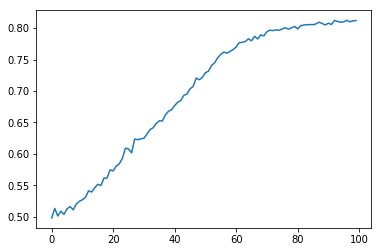

In [15]:
plt.plot(hist[1])